# Figure 4 (long waits)
The goal of this experiment is to estimate the dynamics of the optic flow memory by explicitly modulating the wait duration in a similar experiment as in Fig. 1.

Fish experienced 3-s open-loop motion (*priming*), followed by 10-s closed-loop motion (*probe*), with variable durations of wait periods in between.

In [1]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
import colorcet as cc
from homr_util import *
from tqdm import tqdm

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
# Find data
data_dir = './data/fig4_02'
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 35 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- Down sample data to 20 Hz
- Cut out snippet around each stimulus epoch, sort by epoch type

In [4]:
bin_dt = 1/20

all_fvtraces = []

# Define time bins so that the probe start is 0
# to glacefully deal with variable epoch lengths
time_bin = np.arange(-24,10,bin_dt)
binned_t = (time_bin[1:]+time_bin[:-1])/2

for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # timestamp (stimulus rate, 60Hz-ish)
    t_s = exp.stimulus_log['t'].to_numpy()
    # fish swim effort
    fv = exp.stimulus_log['CLLDGOO_fish_vel'].to_numpy() * exp.stimulus_log['CLLDGOO_fish_swimming'].to_numpy() * exp.stimulus_log['CLLDGOO_vigor_gain'].to_numpy()
        
    # prepare lists to store data
    fvtraces  = [[] for i in range(10)]
    
    # go through epochs
    for epoch in slog:
        
        # first, figure out which type of epoch this was
        pre_dir  = epoch['vel_pre1']>0
        wait_dur = epoch['duration']-18
        epoch_id = int(np.log2(wait_dur)) + pre_dir*5 
        
        # calculate time stamps
        duration = epoch['duration']
        t_end = epoch['t_stop']
        t_start = t_end - duration
        
        # cut out snippets (trust end more than start)
        this_epoch_ind = np.logical_and(t_s>t_start, t_s<=t_end)
        this_t = t_s[this_epoch_ind]
        this_t = this_t - t_start - wait_dur - 8 
        
        # do binning
        binned_fv = binned_statistic(this_t, fv[this_epoch_ind], bins=time_bin)[0]
        
        # saving
        fvtraces[epoch_id].append(binned_fv)
    
    all_fvtraces.append(fvtraces)

100%|████████████████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.01it/s]


In [5]:
# Conversion to numpy array 
all_fvtraces = np.asarray(all_fvtraces)

In [6]:
# average traces over fish and trial
trial_mean_fvtraces = np.nanmean(all_fvtraces, axis=2)
fish_mean_fvtraces = np.mean(trial_mean_fvtraces, axis=0)
fish_sem_fvtraces = np.std(trial_mean_fvtraces, axis=0)/np.sqrt(n_fish)

# average over time
mean_probe_fv = np.nanmean(all_fvtraces[:, :, :, (binned_t>0) * (binned_t<10)], axis=3)

# over trials
fish_mean_probe_fv = np.mean(mean_probe_fv, axis=2)

# over fish
group_mean_pfv = np.mean(fish_mean_probe_fv, axis=0)
group_sem_pfv = np.std(fish_mean_probe_fv, axis=0) / np.sqrt(n_fish)

# calculate by-direction difference (normalized by mean fv over all conditions)
directional_fv_diff = (fish_mean_probe_fv[:, 5:] - fish_mean_probe_fv[:, :5]) / np.mean(fish_mean_probe_fv, axis=1)[:, None]

# calculate mean and sem across fish
mean_dfvd = np.mean(directional_fv_diff, axis=0)
sem_dfvd = np.std(directional_fv_diff, axis=0)/np.sqrt(n_fish)

# prepare x axis
wait_durs = 2**np.arange(5)

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_7396\1722505066.py:2: RuntimeWarning: Mean of empty slice
  trial_mean_fvtraces = np.nanmean(all_fvtraces, axis=2)


## Panels
### Fig. 4F (Probe effort over time, by primimng directions and wait durations)

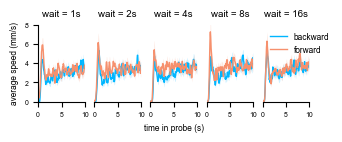

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(3.5,1))
for i in range(5):
    ax[i].fill_between(binned_t, fish_mean_fvtraces[i, :]-fish_sem_fvtraces[i, :], fish_mean_fvtraces[i, :]+fish_sem_fvtraces[i, :], alpha=0.2, color=cc.cm.CET_D11(0.0))
    ax[i].fill_between(binned_t, fish_mean_fvtraces[i+5, :]-fish_sem_fvtraces[i+5, :], fish_mean_fvtraces[i+5, :]+fish_sem_fvtraces[i+5, :], alpha=0.2, color=cc.cm.CET_D11(1.0))
    ax[i].plot(binned_t, fish_mean_fvtraces[i, :], color=cc.cm.CET_D11(0.0), label='backward')
    ax[i].plot(binned_t, fish_mean_fvtraces[i+5, :], color=cc.cm.CET_D11(1.0), label='forward')
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,8)
    ax[i].set_title('wait = {}s'.format(2**i))
    toggle_spines(ax[i], 0, 1, 0, i==0)
ax[2].set_xlabel('time in probe (s)')
ax[0].set_ylabel('average speed (mm/s)')
ax[4].legend()

plt.savefig('./svgs/Fig4F.svg', format='svg')
plt.show()


### Fig. 4GH (Time averaged probe effort over and their by-direction differences)

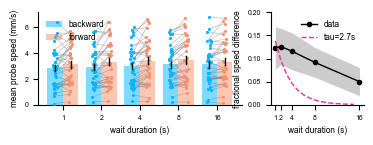

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(4.2, 1.2), width_ratios=(2.2,1))

# Mean probe swim, by wait duration and primimng directions
ax[0].bar(np.arange(5)-0.2, group_mean_pfv[:5], width=0.4, color=cc.cm.CET_D11(0.0), alpha=0.5, label='backward')
ax[0].bar(np.arange(5)+0.2, group_mean_pfv[5:], width=0.4, color=cc.cm.CET_D11(1.0), alpha=0.5, label='forward')
for i in range(5):
    # individual data
    jitter = (np.random.rand(n_fish)-0.5) * 0.1
    
    ax[0].plot(np.vstack((jitter+i-0.2, jitter+i+0.2)), fish_mean_probe_fv[:, (i,i+5)].T, color=(0.5,0.5,0.5), alpha=0.5, lw=0.5)
    
    ax[0].scatter(jitter+i-0.2, fish_mean_probe_fv[:, i], s=5, color=cc.cm.CET_D11(0.0), zorder=3)
    ax[0].scatter(jitter+i+0.2, fish_mean_probe_fv[:, i+5], s=5, color=cc.cm.CET_D11(1.0), zorder=3)
    
    # error bar
    ax[0].plot((i-0.2, i-0.2), (group_mean_pfv[i]-group_sem_pfv[i], group_mean_pfv[i]+group_sem_pfv[i]), 'k-', zorder=5)
    ax[0].plot((i+0.2, i+0.2), (group_mean_pfv[i+5]-group_sem_pfv[i+5], group_mean_pfv[i+5]+group_sem_pfv[i+5]), 'k-', zorder=5)
    
ax[0].set_ylabel('mean probe speed (mm/s)')
ax[0].set_xticks(np.arange(5))
ax[0].legend()

# fractional difference
ax[1].fill_between(wait_durs, mean_dfvd-sem_dfvd, mean_dfvd+sem_dfvd, color=(0,0,0), alpha=0.2)
ax[1].plot(wait_durs, mean_dfvd, 'ko-', label='data', markersize=3)
ax[1].plot(np.arange(1,16), np.exp(np.arange(1,16)/(-2.7))*0.2, linestyle='--', color=(0.9,0.2,0.6), label='tau=2.7s')
ax[1].legend()

ax[1].set_ylabel('fractional speed difference')
ax[1].set_ylim(0,0.2)
ax[1].set_yticks(np.arange(0, 0.25, 0.05))
ax[1].set_xticks(2**np.arange(5))

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    axx.set_xticklabels(2**np.arange(5))
    axx.set_xlabel('wait duration (s)')
    
plt.savefig('./svgs/Fig4GH.svg', format='svg')
plt.show()